In [1]:
# Utils
import os
import numpy as np 
import pandas as pd
import cv2
from IPython.display import clear_output as cls
import imutils
import zipfile

# Modeling
import tensorflow as tf
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D as GAP
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# pre-trained model
from keras.applications import ResNet50V2

In [1]:
# defining main directory
main_directory = r'F:\Project1\images\New Dataset\RCNN/'
# checkin classes names
class_names = sorted(os.listdir(main_directory))
# checking number of classes
n_classes = len(class_names)

# class distribution 
class_diss = [len(os.listdir(main_directory + name)) for name in class_names]
print(f"Total Number of classes : {n_classes} \nClasse Names : {class_names}")

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 18-19: malformed \N character escape (513243967.py, line 2)

In [3]:
fig = px.pie(names=class_names, values=class_diss, title="Class Distribution", hole=0.4)
fig.update_layout({'title':{'x':0.5}})
fig.show()

In [4]:
def crop_brain_contour(image, plot=False):
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
        
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

In [5]:
# resizing and cropping images
subdir_list = os.listdir(main_directory)

target_size = (630, 630)

for subdir in subdir_list:
    subdir_path = os.path.join(main_directory, subdir)
    if os.path.isdir(subdir_path):
        image_list = os.listdir(subdir_path)
        for image_name in image_list:
            # read image
            image = cv2.imread(os.path.join(subdir_path, image_name))
            # resize image
            image = cv2.resize(image, target_size)
            # crop image
            image = crop_brain_contour(image)
            # replacing the old image in directory
            cv2.imwrite(os.path.join(subdir_path, image_name), image)

In [6]:
# data loading and augmentation
datagen = ImageDataGenerator(rotation_range=15,
                             width_shift_range=0.05,
                             height_shift_range=0.05,
                             rescale=1./255,
                             shear_range=0.05,
                             brightness_range=[0.1, 1.5],
                             horizontal_flip=True,
                             vertical_flip=True,
                             validation_split=0.3)

# loading training set
train = datagen.flow_from_directory(main_directory, class_mode='binary', target_size=(630,630), shuffle=True, batch_size=16,
subset='training')

# loading validation set
validation = datagen.flow_from_directory(main_directory, class_mode='binary', target_size=(630,630), shuffle=True, batch_size=16,
subset='validation')

Found 1750 images belonging to 2 classes.
Found 750 images belonging to 2 classes.


In [7]:
def show_images(GRID= [5,5], model=None, size = (20,20), data=train):
    n_rows = GRID[0]
    n_cols = GRID[1]
    n_images = n_rows * n_cols

    i = 1
    plt.figure(figsize=size)
    for images, labels in data:
        id = np.random.randint(len(images))
        image, label = images[id], class_names[int(labels[id])]
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)
        
        if model is None:
            title = f"Class : {label}"
        else:
            pred = class_names[int(np.argmax(model.predict(image[np.newaxis, ...])))]
            title = f"Org : {label}, Pred : {pred}"
            cls()
                    
        plt.title(title)
        plt.axis('off')
        
        i+=1
        if i>=(n_images+1):
            break
            
    plt.tight_layout()
    plt.show()

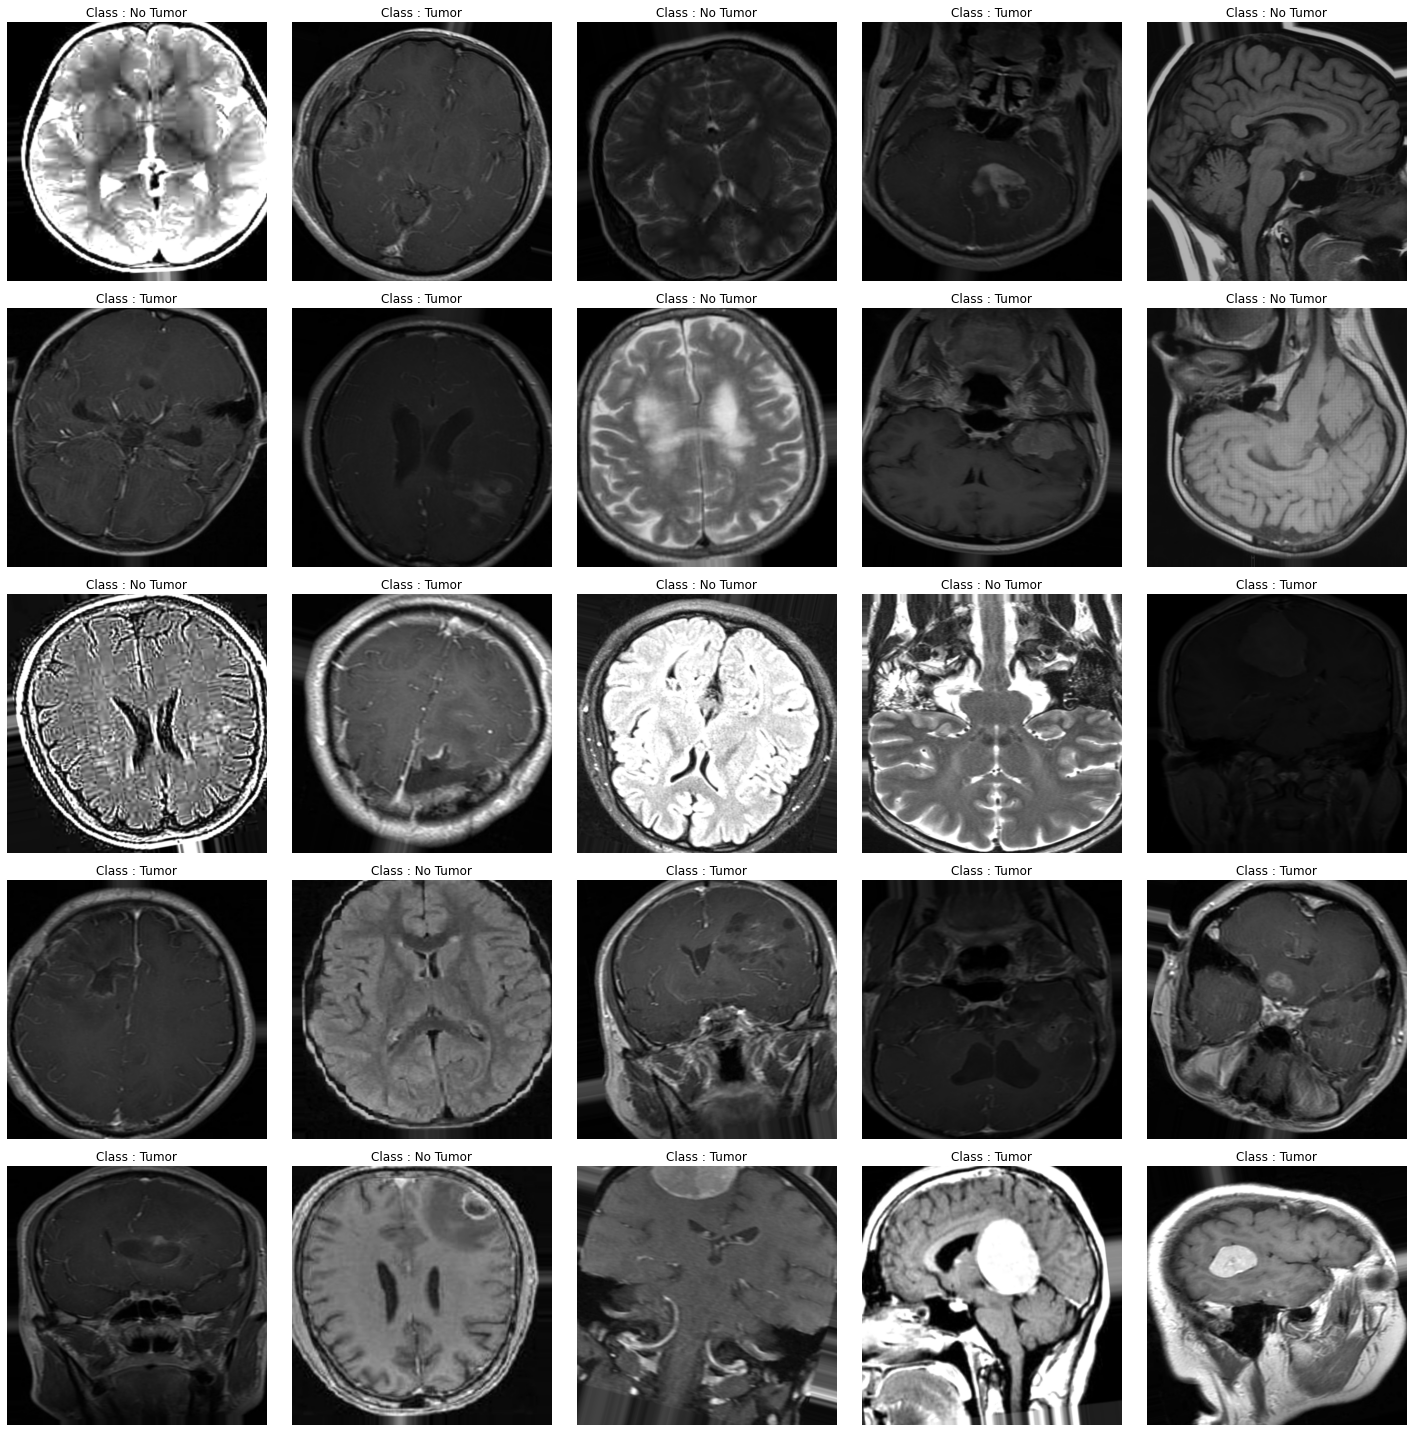

In [8]:
show_images()

In [ ]:
# defining the base pre-trained model
base_model = ResNet50V2(input_shape=(630,630,3), include_top=False)
base_model.trainable = False

# defining our model
name = "ResNet50V2"
model = Sequential([
    base_model, 
    GAP(),
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    Dense(n_classes, activation='softmax'),
], name=name)

# compiling model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# training model
history = model.fit(train, validation_data=validation, epochs=30)

Epoch 1/30
110/110 [==============================] - 1767s 16s/step - loss: 0.2367 - accuracy: 0.9051 - val_loss: 0.1376 - val_accuracy: 0.9493
Epoch 2/30
 17/110 [===>..........................] - ETA: 17:44 - loss: 0.1602 - accuracy: 0.9265